In [122]:
#!unzip 'drive/MyDrive/dog-breed-identification.zip' -d 'drive/MyDrive'

End to end multi-class Dog breed classification

### 1.Get our workspace ready

In [123]:
# Import TensorFlow into colab
import tensorflow as tf
print('TF version:',tf.__version__)

# Import TensorFlow Hub
import tensorflow_hub as hub
print('TF hub version:',hub.__version__)

# Make sure we are using GPU
print('GPU', 'available' if tf.config.list_physical_devices('GPU')
else 'not available')

TF version: 2.19.0
TF hub version: 0.16.1
GPU not available


In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Get our data ready


In [125]:
# Lets check the labels data first
import pandas as pd
labels_csv = pd.read_csv('drive/MyDrive/Dog-Breed-Data /labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [126]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

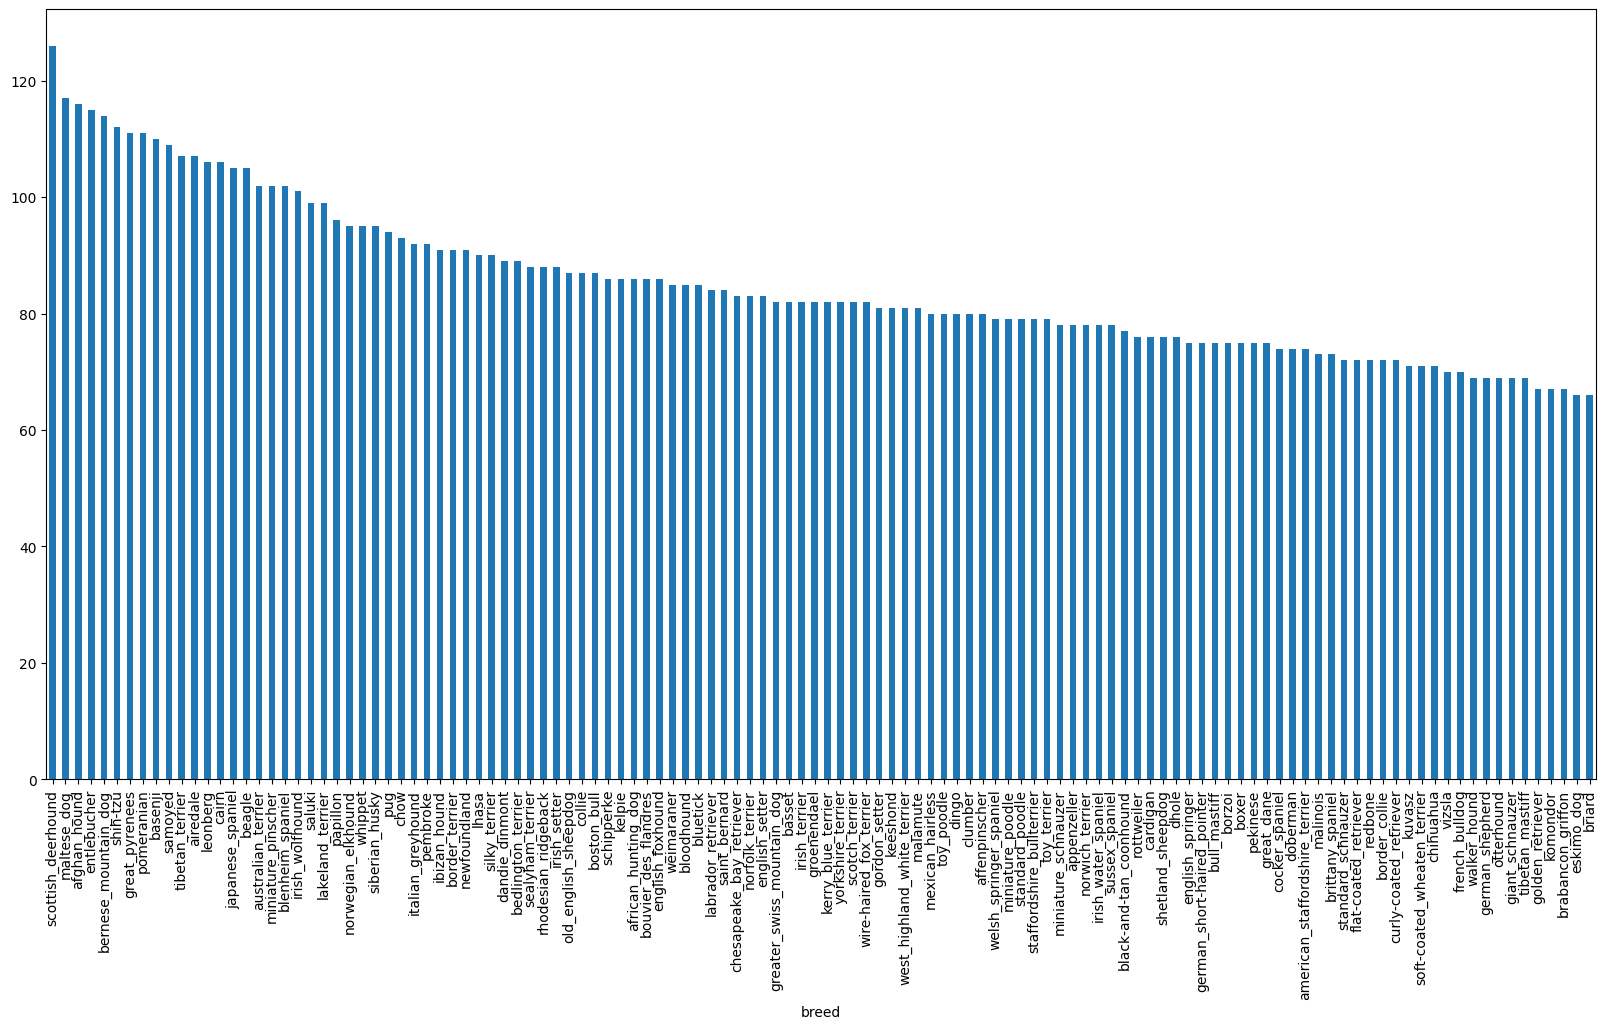

In [127]:
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10))

In [128]:
labels_csv['breed'].value_counts().median()

82.0

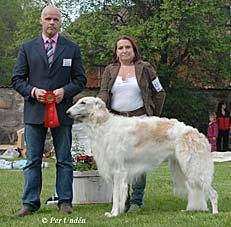

In [129]:
# Lets view an image
from IPython.display import Image
Image('/content/drive/MyDrive/Dog-Breed-Data /train/002a283a315af96eaea0e28e7163b21b.jpg')

Let's get a list of all the pathnames of our image

In [130]:
filenames = ['/content/drive/MyDrive/Dog-Breed-Data /train/'+fname+'.jpg' for fname in labels_csv['id']]
filenames[:5]

['/content/drive/MyDrive/Dog-Breed-Data /train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog-Breed-Data /train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog-Breed-Data /train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog-Breed-Data /train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog-Breed-Data /train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

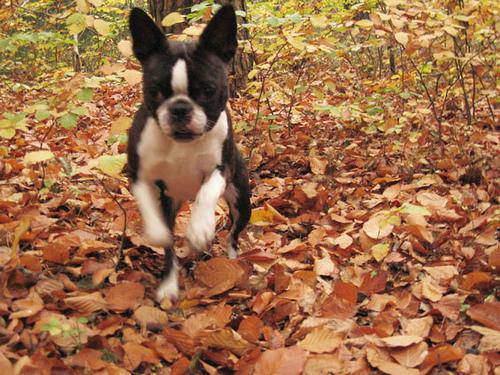

In [131]:
Image('/content/drive/MyDrive/Dog-Breed-Data /train/000bec180eb18c7604dcecc8fe0dba07.jpg')

In [132]:
# Check if filenames matches actual image size
import os
os.listdir('/content/drive/MyDrive/Dog-Breed-Data /train/')[:10]

['e673bb6ca717b8dffe3b5ba35da07a83.jpg',
 'e13d468a13740374b13ad373d508c58c.jpg',
 'dde1f99c744c9c5f3bd471bd390314d6.jpg',
 'e88f4a70305e582965569c4ca91c34b8.jpg',
 'e3b8f3589a7286ebe017300bf780c279.jpg',
 'e139e3a836bd9c57af5355847b8eb805.jpg',
 'de1da53a478bd391889a98ee9063c2d7.jpg',
 'e12b685cebb695b56fd1168dd4386582.jpg',
 'e8a902080c150632c8b45b8013d0e540.jpg',
 'e208bfa575753207f240ed5619f93c41.jpg']

In [133]:
import os
if len(os.listdir('/content/drive/MyDrive/Dog-Breed-Data /train/'))== len(filenames):
  print('File names match. Proceed')
else:
  print('File names do not match')

File names match. Proceed


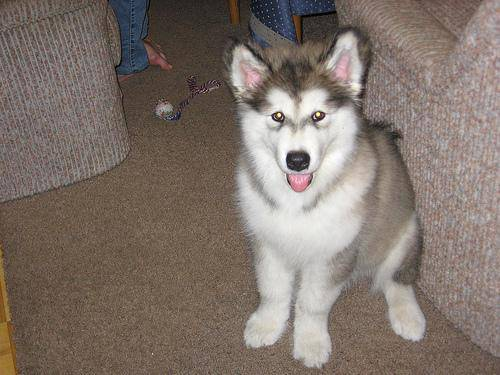

In [134]:
Image(filenames[3000])

Let's prepare our labels

In [135]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [136]:
len(labels)

10222

In [137]:
#  See if labels match filenames
if len(labels) == len(filenames):
  print('They match')
else:
  print('They does not match')

They match


In [138]:
# Find the uniue breeds
unique_breed = np.unique(labels)
len(unique_breed)


120

In [139]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breed

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [140]:
# Turn all labels into boolean array
boolean_labels = [label == unique_breed for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [141]:
len(boolean_labels)

10222

In [142]:
# Example of Turning boolean arrary into integers
print(labels[0])
print(np.where(unique_breed == labels[0])) #index where label occurs
print(boolean_labels[0].argmax()) #index where label occurs in boolean array
print(boolean_labels[0].astype(int)) #there will be 1 where sample label occurs


boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

In [143]:
# Setup X and y variables
X = filenames
y = boolean_labels

In [144]:
len(filenames),len(boolean_labels)

(10222, 10222)

In [145]:
 # Set number of images to use for experimenting(say 1000)
 NUM_IMAGES = 1000 #@param {type:'slider', min:1000,max:10000}

In [146]:
# Lets split data into train and validation sets
from sklearn.model_selection import train_test_split

#Split data
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                 y[:NUM_IMAGES],
                                                 test_size=0.2,
                                                 random_state=1)
len(X_train),len(X_val),len(y_train),len(y_val)

(800, 200, 800, 200)

In [147]:
#lets have a look at the training set
X_train[:5],y_train[:1]

(['/content/drive/MyDrive/Dog-Breed-Data /train/0943d1d4677ab876b52468096baaa2ce.jpg',
  '/content/drive/MyDrive/Dog-Breed-Data /train/187b3a867bb68860208c37aaf43d2115.jpg',
  '/content/drive/MyDrive/Dog-Breed-Data /train/182c9134e07c883dfdc2acfb21184810.jpg',
  '/content/drive/MyDrive/Dog-Breed-Data /train/013c43f40f0fb13fa25ac0c2a70fd48f.jpg',
  '/content/drive/MyDrive/Dog-Breed-Data /train/0ca9280205bd68d201e1d708db3f209d.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fa

Preprocessing Images (turning images into Tenors)


In [148]:
# Convert images into numpy array
from matplotlib.pyplot import imread
image = imread(filenames[30])
image.shape

(338, 450, 3)

In [149]:
image[:2]

array([[[171, 115,  78],
        [170, 114,  77],
        [168, 114,  76],
        ...,
        [190, 167,  91],
        [190, 168,  93],
        [188, 169,  93]],

       [[172, 116,  79],
        [171, 115,  78],
        [169, 115,  77],
        ...,
        [195, 171,  97],
        [195, 173,  98],
        [193, 174,  98]]], dtype=uint8)

In [150]:
# Turning image into Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 450, 3), dtype=uint8, numpy=
array([[[171, 115,  78],
        [170, 114,  77],
        [168, 114,  76],
        ...,
        [190, 167,  91],
        [190, 168,  93],
        [188, 169,  93]],

       [[172, 116,  79],
        [171, 115,  78],
        [169, 115,  77],
        ...,
        [195, 171,  97],
        [195, 173,  98],
        [193, 174,  98]]], dtype=uint8)>

In [151]:
#Define image size
IMG_SIZE =224

#Create a funtion to preprocess our images

def process_image(image_path, img_size=IMG_SIZE):
  '''Takes an image file path and turns it into a Tensor'''
  #Read in an image file
  image = tf.io.read_file(image_path)
  #Turn jpeg image into numerical Tensor with 3 colour channel(red,blue,green)
  image = tf.image.decode_jpeg(image, channels=3)
  #Conver the channel value from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image,tf.float32)
  #Resize the image to our desired value(224,224)
  image = tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  return image

Turning our data int batches (of 32)

In [152]:
#Create a simple function to return a tuple(image,label)

def get_image_label(image_path,label):
  ''' Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image,label)'''

  image= process_image(image_path)
  return image,label

In [153]:
#Demo
(process_image(X[42],y[42]))

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117759],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01

In [154]:
#Define batch size as 32
BATCH_SIZE = 32

#Let's make function to turn X and y into batches
def create_data_batches(X,y=None, batch_size=BATCH_SIZE, valid_data=False,test_data=False):
  '''Creates batches of data out of image(X) and labels(y) pairs.
    Shuffles the data if its training data but doesn't shuffle if it's validation data.
    Also accepts test data as input(no labels)'''

    #If the data is test dataset, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

    #If the data is validation dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print('Creating training data batches....')
    #Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    #Shuffle pathname and labels before mapping image processor funtion is faster than shuffiling images
    data = data.shuffle(buffer_size=len(X))
    data = data.map(get_image_label)
    #Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch


In [155]:
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val, valid_data=True)

Creating training data batches....
Creating validation data batches...


In [156]:
#Check out the different attributes of data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

Visualizing Data Batches

In [157]:
import matplotlib.pyplot as plt

#Create a function for viewing images in a data batch
def show_25_images(images,labels):
  '''Displays a plot of 25 images and their labels from a data batch'''

  #Setup the figure
  plt.figure(figsize=(10,10))
  #Loop through 25 (for displaying 25 images)
  for i in range(25):
    #Create subplots (5rows,5columns)
    ax = plt.subplot(5,5,i+1)
    #Display an image
    plt.imshow(images[i])
    #Add the image label as the title
    plt.title(unique_breed[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis('off')

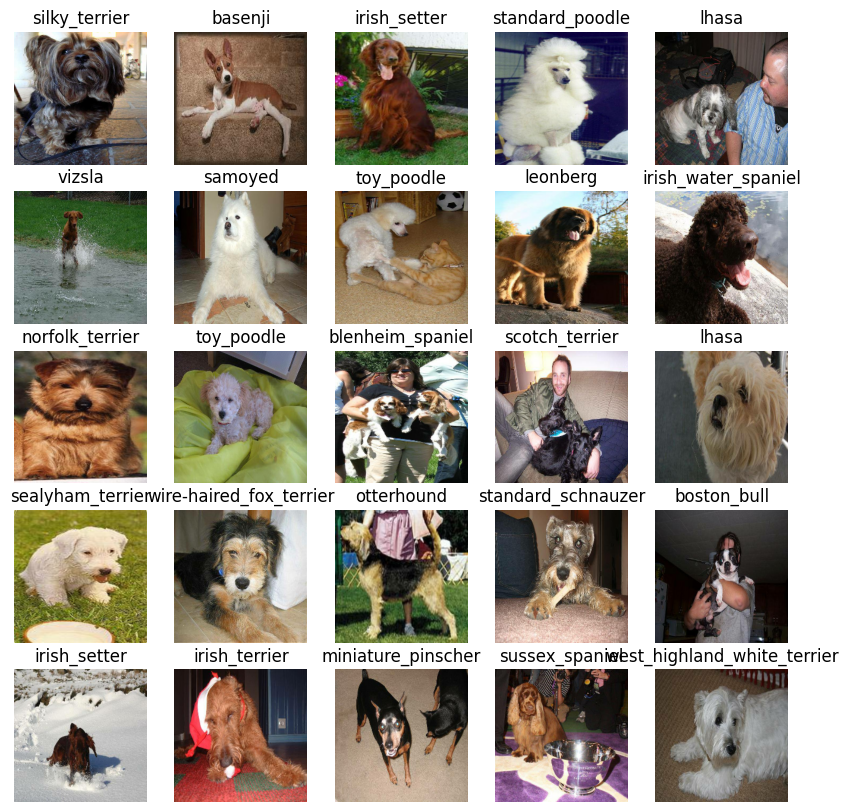

In [158]:
# Now let'svisualize the data  in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels)

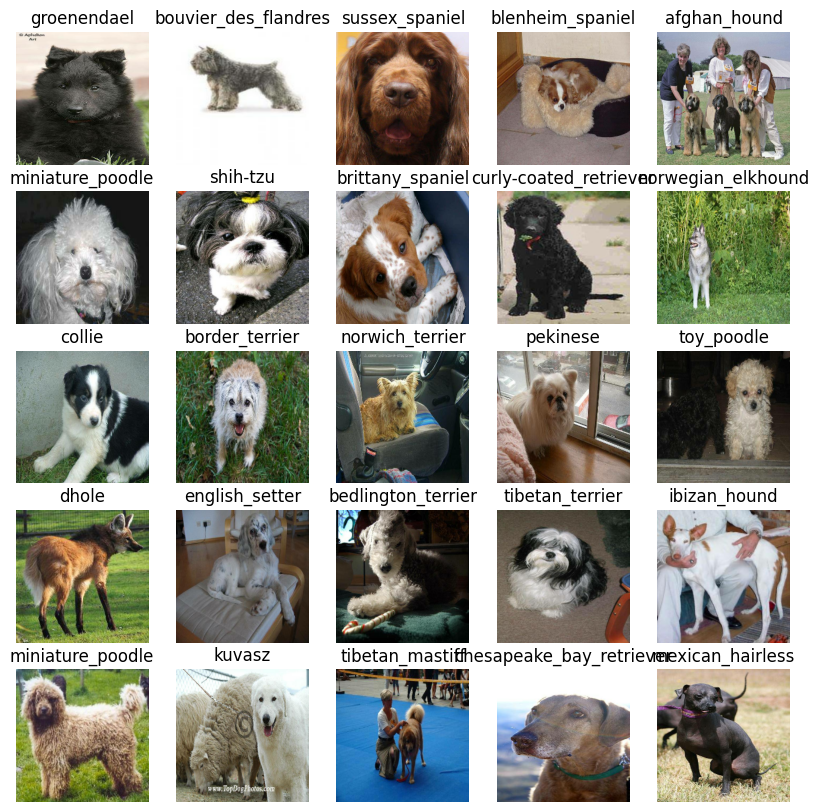

In [159]:
# Now let's visualize validation images
val_iamges , val_labels =  next(val_data.as_numpy_iterator())
show_25_images(val_iamges,val_labels)

### Building a model

In [160]:
# Setup input shape to the model
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3]

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breed)

# Setup model URL from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'



 Let's put our inputs,outputs and model together into Keras deep learning model.


Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'l be getting).
* Returns the model.

In [ ]:
# Create a function which builds a Keras model

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print('Building model with:',model_url)

  # Define a custom layer to wrap the KerasLayer from TensorFlow Hub
  class HubLayer(tf.keras.layers.Layer):
      def __init__(self, model_url, trainable=False, **kwargs):
          super().__init__(**kwargs)
          self.hub_layer = hub.KerasLayer(model_url, trainable=trainable)

      def call(self, inputs):
          return self.hub_layer(inputs)

  # Setup the model
  model = tf.keras.Sequential([
      HubLayer(model_url, trainable=False), # Layer 1: Feature extractor from TF Hub
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                            activation='softmax') # Layer 2: Output layer
  ])

  # Complie the model
  model.compile(
       loss=tf.keras.losses.CategoricalCrossentropy(),
       optimizer=tf.keras.optimizers.Adam(),
       metrics=['accuracy'])

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

def create_model(input_shape, output_shape, model_url):
    """
    Builds a Keras model using a TensorFlow Hub feature extractor.

    Args:
        input_shape (tuple): Shape of input (excluding batch), e.g. (224, 224, 3)
        output_shape (int): Number of output classes.
        model_url (str): URL of the TF Hub feature extractor.

    Returns:
        tf.keras.Model: Compiled Keras model.
    """
    print('Building model with:', model_url)

    # Define custom wrapper layer (optional)
    class HubLayer(tf.keras.layers.Layer):
        def __init__(self, model_url, trainable=False, **kwargs):
            super().__init__(**kwargs)
            self.hub_layer = hub.KerasLayer(model_url, trainable=trainable)

        def call(self, inputs):
            return self.hub_layer(inputs)

    # Build model
    model = tf.keras.Sequential([
        HubLayer(model_url, trainable=False),
        tf.keras.layers.Dense(units=output_shape, activation='softmax')
    ])

    # Compile model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    # Build model explicitly (optional)
    model.build((None,) + input_shape)

    return model


In [162]:
model = create_model()
model.summary()
print(model)

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hub_layer_4 (HubLayer)          │ (None, 1001)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 120)            │       120,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,240 (469.69 KB)

 Trainable params: 120,240 (469.69 KB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential_5, built=True>


Callbacks are helper functions a model can use during training to do such things as save its prgress, check its progress or stop training early if a model stops improving.

Creating TensoBoard callbacks


In [163]:
# Load TensorBoard notebook extentions
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [164]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log dictionary for toring TensorBoard logs
  logdir = os.path.join('/content/drive/MyDrive/Dog-Breed-Data /logs',
                        datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  return tf.keras.callbacks.TensorBoard(logdir)

Creating early stop callback

In [165]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

### Training a model (on subset of data)
Our first model is only going to train on 1000 images, to make sure everything is working.

In [166]:
NUM_EPOCHS=100  #@param {type:"slider", min:10, max:100, step:10}

In [167]:
# Check to see if we are running on GPU
print('GPU available' if tf.config.list_physical_devices('GPU')
           else 'Not available')

Not available


In [168]:
# Build a function to train and return a trained model
def train_model():
  '''Trains a given model and returns the trained version'''
  #Create a model
  model =  create_model()

  #Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(train_data,
            epochs=NUM_EPOCHS,
            validation_data= val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])

  #Return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 212s 8s/step - accuracy: 0.0510 - loss: 5.2420 - val_accuracy: 0.2750 - val_loss: 3.2625
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6571 - loss: 1.8759 - val_accuracy: 0.5250 - val_loss: 2.0321
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9471 - loss: 0.5774 - val_accuracy: 0.5750 - val_loss: 1.5801
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9911 - loss: 0.2628 - val_accuracy: 0.6000 - val_loss: 1.4299
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.9993 - loss: 0.1378 - val_accuracy: 0.6350 - val_loss: 1.3424
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 1.0000 - loss: 0.1000 - val_accuracy: 0.6300 - val_loss: 1.3107
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 1.0000 - loss: 0.0748 - val_accuracy: 0.6300 - val_loss: 1.2832
Epoch 8/100
25/25

it looks like our model is overfitting because its performing far better on the training set than in the validation set.
overfitting is good it means our model is learning.

###  Checking the TensorBoard logs

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Dog-Breed-Data\ /logs

<IPython.core.display.Javascript object>

### Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data,verbose=1)
predictions

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


array([[1.26489240e-03, 6.84941479e-04, 6.17346261e-04, ...,
        1.70519645e-03, 3.64681255e-05, 4.55754234e-05],
       [4.65075951e-03, 1.04294636e-03, 4.37424351e-05, ...,
        1.09547377e-03, 2.11979379e-04, 6.15301426e-04],
       [3.13761906e-04, 1.14362454e-03, 9.11629642e-04, ...,
        7.68653990e-05, 2.73610582e-04, 7.28623068e-04],
       ...,
       [4.39903306e-06, 4.89434497e-05, 2.47267872e-05, ...,
        2.19232716e-05, 1.17623122e-05, 5.27344037e-06],
       [4.34926660e-05, 1.73895867e-04, 4.83963311e-01, ...,
        5.25280787e-03, 8.18616027e-05, 1.13994756e-03],
       [2.38091870e-05, 5.46098599e-05, 2.84827023e-04, ...,
        1.65166406e-04, 9.34959855e-04, 1.02409904e-04]], dtype=float32)

In [ ]:
predictions.shape,len(y_val),len(unique_breed)

((200, 120), 200, 120)

In [ ]:
np.sum(predictions[0]) #due to softmax- converts component into intervals of 0-1 and the total is close to 1

np.float32(1.0000004)

In [ ]:
# First Predictions

index = 30
print(predictions[0])
print(f'Max value (probability of prediciotn): {np.max(predictions[index])}')
print(f'Sum:{np.sum(predictions[index])}')
print(f'Max index: {np.argmax(predictions[index])}')
print(f'Predicted label: {unique_breed[np.argmax(predictions[index])]}')


[1.26489240e-03 6.84941479e-04 6.17346261e-04 5.42658847e-04
 3.68620735e-04 8.24976305e-04 1.83361990e-04 5.03216696e-04
 5.59507043e-06 1.17735544e-05 8.90177325e-05 8.67307419e-04
 7.71549603e-05 2.72178841e-05 4.28126805e-04 7.21538236e-05
 7.37112202e-03 6.75041447e-05 4.97351459e-04 2.87926759e-05
 5.28892677e-04 8.44379829e-05 1.48994353e-04 2.04542797e-04
 1.17201289e-05 3.31085903e-04 1.83000186e-04 1.45094571e-04
 5.03478339e-04 2.82109715e-04 5.85822668e-03 5.71317105e-06
 8.64282483e-05 2.64668884e-03 1.02815707e-03 1.63679957e-04
 1.07027823e-02 1.04732648e-03 8.33229104e-04 2.70103210e-05
 7.40106479e-05 6.42430896e-05 1.17831578e-05 1.08763613e-02
 2.87301396e-03 6.83933249e-05 6.58736273e-04 5.33631101e-05
 2.58451415e-04 1.51577275e-04 2.18557961e-05 7.20661337e-05
 1.82311080e-04 4.12829941e-05 8.35511684e-01 1.72634015e-03
 3.09753319e-04 4.33733112e-05 3.64006672e-04 1.54750785e-04
 2.93265002e-05 2.33864121e-05 5.19925123e-03 1.99901080e-03
 5.58474683e-04 4.300833

In [ ]:
unique_breed[74]

'mexican_hairless'

This functionality good but wer have to able to do it at scale.And it would be evne better if we could see the image the prediciton is being made on.

In [ ]:
# Turn predicton probabilities into their respective label(easier to understand)

def get_pred_label(prediction_probabilities):
  ''' Turns an array of prediction probabilities into a label'''
  return unique_breed[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of predictio probabilities
pred_label = get_pred_label(predictions[18])
pred_label

'lhasa'

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Since our validation data is in batchdataset we have to unbatchify it to make predicitons on the validation images and then copare those predictions to the alidation labels(the truth labels)

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  '''Takes a batched dataset of (image,label)Tensors
  and returns separate arrays of images and labels.'''
  images=[]
  labels=[]

  #Loop through
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breed[np.argmax(label)])
  return images,labels

In [ ]:
#Unbatchify the validation data
val_images,val_labels = unbatchify(val_data)
val_images[0],val_labels[0]

(array([[[0.96044296, 0.9212273 , 0.8820116 ],
         [0.96320033, 0.92398465, 0.88476896],
         [0.96320033, 0.92398465, 0.88476896],
         ...,
         [0.95294124, 0.91372555, 0.8745099 ],
         [0.95294124, 0.91372555, 0.8745099 ],
         [0.95294124, 0.91372555, 0.8745099 ]],
 
        [[0.96820897, 0.9289933 , 0.8897776 ],
         [0.97159004, 0.93237436, 0.8931587 ],
         [0.97195387, 0.9327382 , 0.8935225 ],
         ...,
         [0.96018916, 0.9209735 , 0.8817578 ],
         [0.96018916, 0.9209735 , 0.8817578 ],
         [0.96018916, 0.9209735 , 0.8817578 ]],
 
        [[0.965555  , 0.9263393 , 0.88712364],
         [0.9683124 , 0.9290967 , 0.889881  ],
         [0.9683124 , 0.9290967 , 0.889881  ],
         ...,
         [0.96894264, 0.92972696, 0.8905113 ],
         [0.96894264, 0.92972696, 0.8905113 ],
         [0.96894264, 0.92972696, 0.8905113 ]],
 
        ...,
 
        [[0.37830937, 0.4555765 , 0.26835716],
         [0.13986346, 0.20766863, 0.06694

In [ ]:
get_pred_label(val_labels[0]) # To check if our function has worked

'affenpinscher'

### Visualizing our data

In [ ]:
# Function to visualize
def plot_pred(prediction_probabilities, labels,images,n=1):
  ''' View the predictions, ground truth and image for sample n '''
  pred_prob,true_label,image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  #Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the titiel depending on if the predictions based or right or wrong
  if pred_label == true_label:
    color='green'
  else:
    color='red'

  # Change plot title
  plt.title('{} {:2.0f}% {}'.format(pred_label,
                                   np.max(pred_prob)*100,
                                   true_label),
                                    color=color)


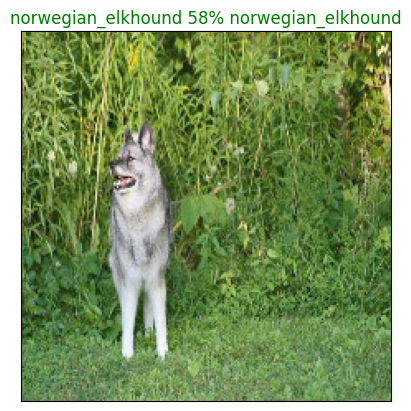

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=9)

We have made a function to visualize our predictions. Now lets make another to view our models top 10 predictions.

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  ''' Plus the top 10 highest predicton confidences along with the truth label for sample n '''
  pred_prob, true_label = prediction_probabilities[n],labels[n]

  # Get the predicted label
  pred_label= get_pred_label(pred_prob)

  # Find thr top 10 predciton confidence indexes
  top_10_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 predcition confidence values
  top_10_values = pred_prob[top_10_indexes]
  # Find the top 10 predciton labels
  top_10_labels = unique_breed[top_10_indexes]

  #Setup plot
  top_plot = plt.bar(np.arange(len(top_10_labels)),
                     top_10_values,
                     color='lightblue')
  plt.xticks(np.arange(len(top_10_labels)),
             labels=top_10_labels,
             rotation='vertical')

  # Change colour of truth label
  if np.isin(true_label, top_10_labels):
    top_plot[np.argmax(top_10_labels==true_label)].set_color('green')
  else:
    pass


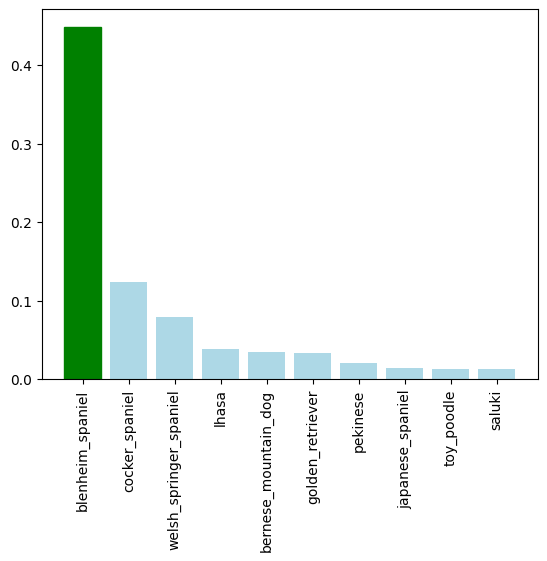

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=3)

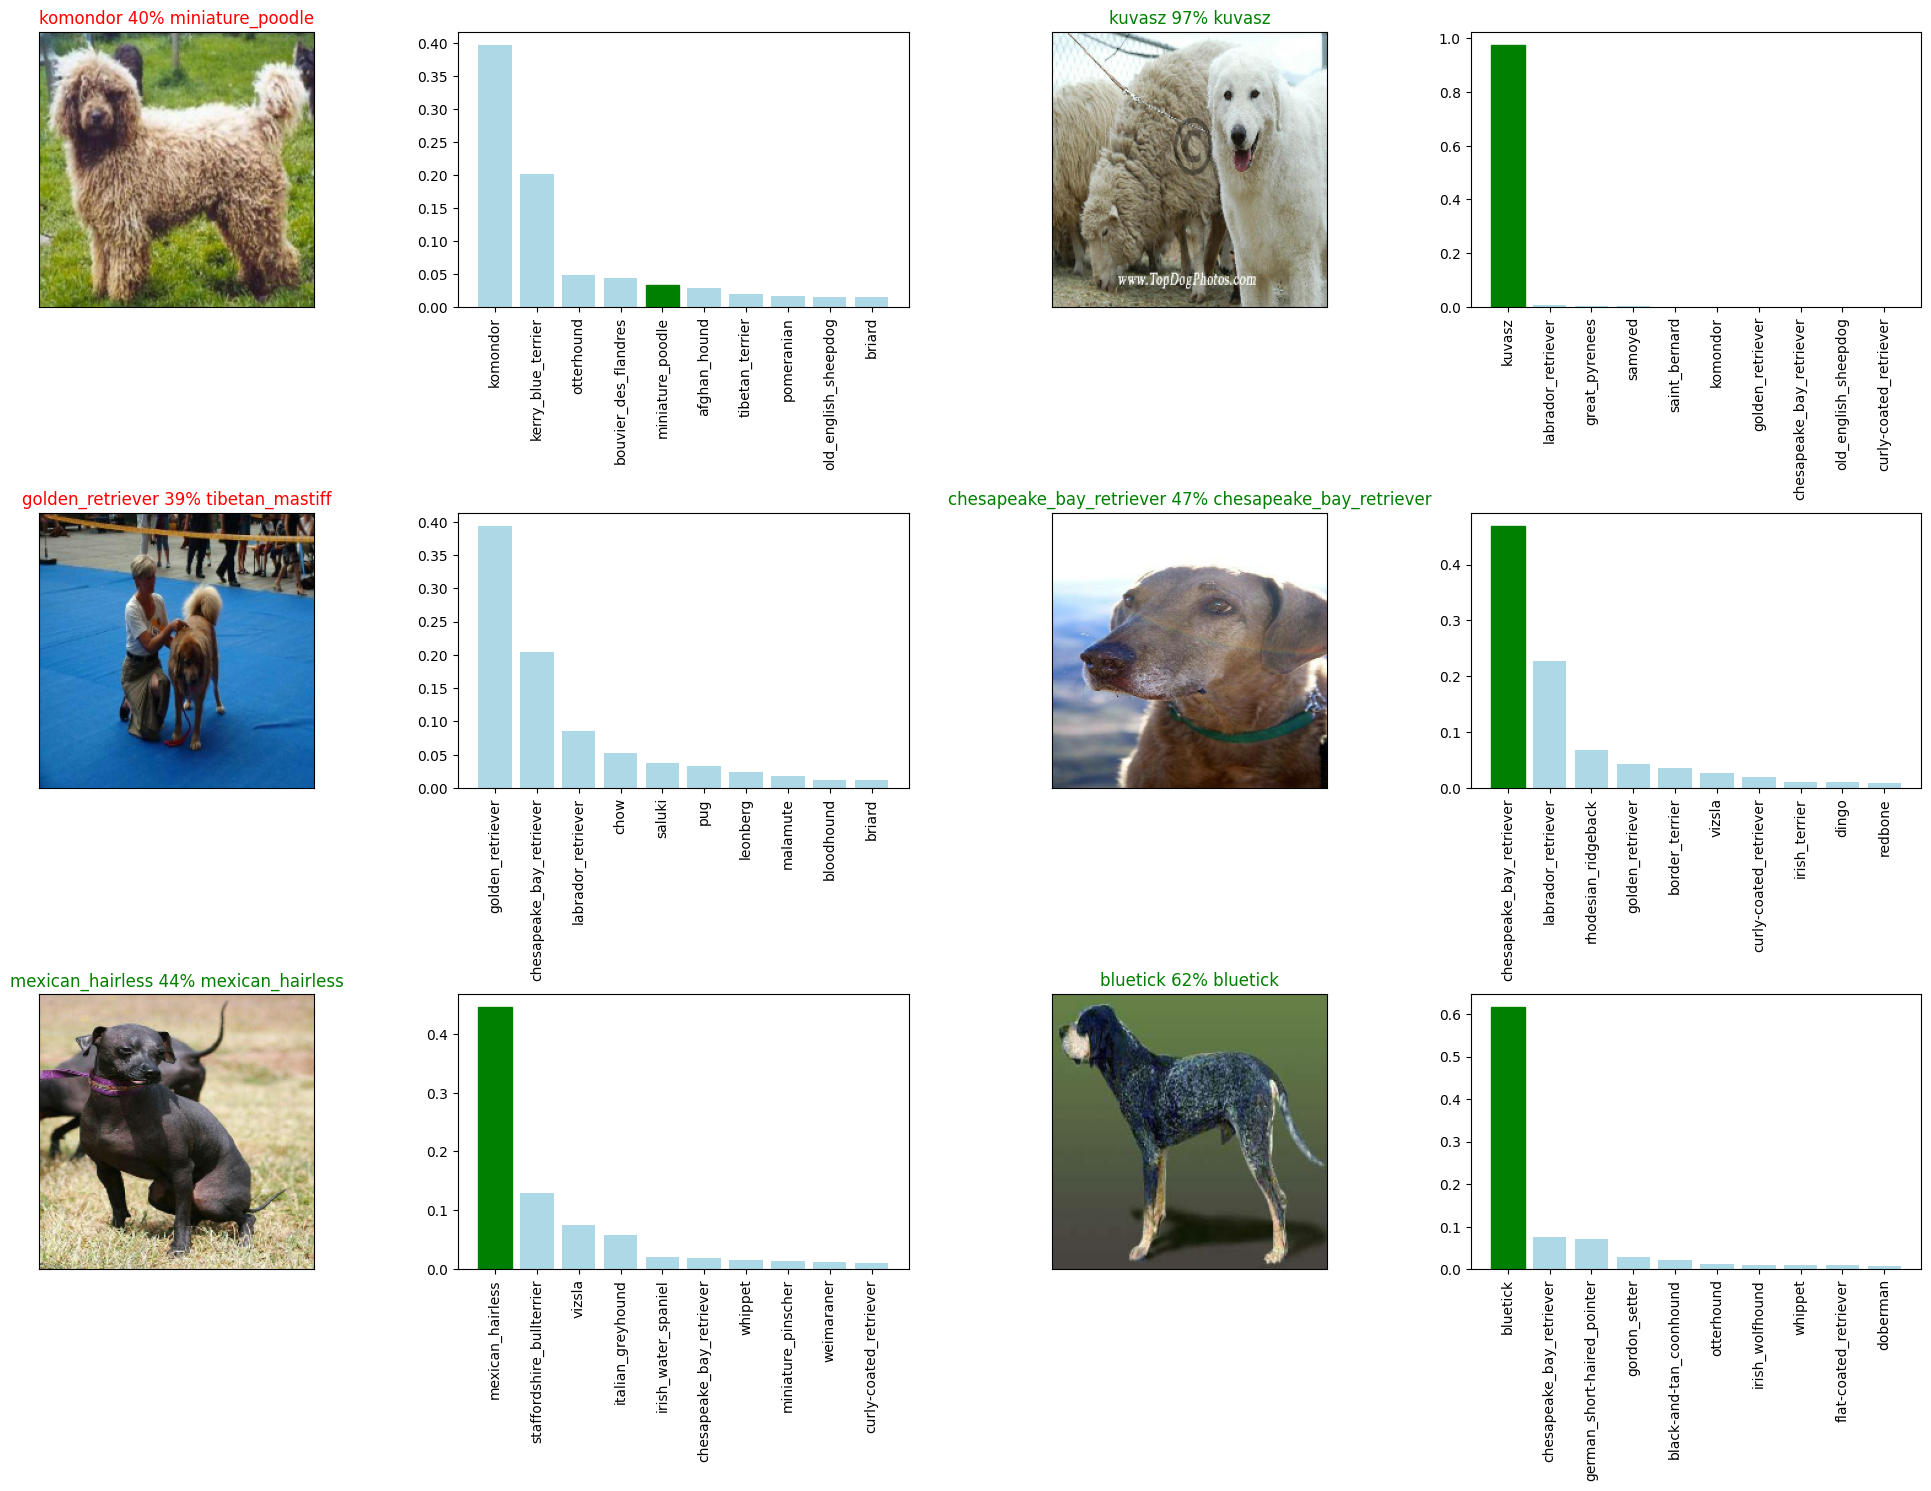

In [ ]:
#Lets check out some predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
            labels=val_labels,
            n=i+i_multiplier)
plt.tight_layout(h_pad=1.0) #gives some space
plt.show()

### Saving and reloading a trained model

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  ''' Saves a given model in a models directory and appends a suffix(string) '''

   # Create a model directory pathname with current time
  modeldir = os.path.join('/content/drive/MyDrive/Dog-Breed-Data /models',
                        datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  model_path = modeldir + '-' + suffix + '.keras' #..keras is save format of model
  print(f'Saving model to: {model_path}....')
  model.save(model_path)
  return model_path


In [ ]:
# Create a function to reload a trained model
def load_model(model_path,safe_mode=False):
  ''' Loads a saved model from a specified path'''
  print(f'Loading saved model from: {model_path}')
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={'KerasLayer':hub.KerasLayer})
  return model

In [ ]:
# Save our model trained on 1000 images
save_model(model,suffix='1000-images-mobilenetv2-Adam')

Saving model to: /content/drive/MyDrive/Dog-Breed-Data /models/20251022-11591761134390-1000-images-mobilenetv2-Adam.keras....


'/content/drive/MyDrive/Dog-Breed-Data /models/20251022-11591761134390-1000-images-mobilenetv2-Adam.keras'

In [ ]:
# Load a trained model - Udemy (for older version of tensor flow)
loadded_1000_images_model = load_model('/content/drive/MyDrive/Dog-Breed-Data /models/20251017-07031760684623-1000-images-mobilenetv2-Adam.keras')

NameError: name 'load_model' is not defined

In [ ]:
# Load a trained model - Udemy
import keras
loaded_1000_images_model = keras.models.load_model('/content/drive/MyDrive/Dog-Breed-Data /models/20251017-07031760684623-1000-images-mobilenetv2-Adam.keras',
                                custom_objects={'KerasLayer': hub.KerasLayer},
                                safe_mode=False)


In [ ]:
# Evaluate the presaved model
model.evaluate(val_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6062 - loss: 1.3625


[1.2583355903625488, 0.6299999952316284]

In [ ]:
#Evaluate the loaded model - Udemy
loaded_1000_images_model.evaluate(val_data)

TypeError: Exception encountered when calling Lambda.call().

[1m'dict' object is not callable[0m

Arguments received by Lambda.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • mask=None
  • training=False

## Trianing a big odog model (on full data)

In [ ]:
len(X), len(y)

In [ ]:
len(X_train),len(y_train)

In [ ]:
# Create a data batch with full data set
full_data = create_data_batches(X,y)

In [ ]:
full_data

In [ ]:
# Create a model for full model
full_model = create_model()

In [ ]:
# Create full mode callback
full_model_callbacks = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_callbacks_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                                        patience=3)



In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_callbacks,full_model_callbacks_early_stopping])

In [ ]:
# Save the full model
save_model(full_model,suffix='full-model-mobilenetv2-Adam')

In [ ]:
# Load the full model
loaded_full_model = load_model('/content/drive/MyDrive/Dog-Breed-Data /models/20251022-09401761126004-full-model-mobilenetv2-Adam.keras')

### Making predicitons on test dataset

In [ ]:
# Load test image file names
test_path = '/content/drive/MyDrive/Dog-Breed-Data /test'
test_filenames = [test_path + filename for filename in os.listdir(test_path)]
test_filenames[:5]

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames,test_data=True)

In [ ]:
test_data

Note: Calling  predict on our full model and passing it the test data batch will take a long time to run

In [ ]:
# Make predictions on test data batch using the loaded full model
test_preds = loaded_full_model.predict(test_data,
                                       verbose=1)

In [ ]:
# Save predicitons (Numpy array) to csv file(fro access later)
np.savetxt('/content/drive/MyDrive/Dog-Breed-Data /test_preds.csv',
           test_preds,
           delimiter=',')

In [ ]:
# Load  predictions from csv file
test_preds = np.loadtxt('/content/drive/MyDrive/Dog-Breed-Data /test_preds.csv',
                        delimiter=',')

## Preparing test dataset predictions for Kaggle


In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=['id']+ list(unique_breed))
preds_df.head()

In [ ]:
# Append test image id to prediction dataframe
test_ids = [os.path.splitext(filename)[0] for filename in os.listdir(test_path)]
preds_df['id'] = test_ids
preds_df.head()

In [ ]:
# Add the prediciton probabilities to each dog breed column
preds_df[list[unique_breed]] = test_preds
preds_df.head()

In [ ]:
# Savve our predicitions dataframe to csv fro submission to kaggle
preds_df.to_csv('/content/drive/MyDrive/Dog-Breed-Data /preds_df.csv',
                 index=False)

Prediciting on our custom images

In [ ]:
# Get custom image filepaths
custom_path = '/content/drive/MyDrive/Dog-Breed-Data /CustomImages'
custom_filenames = [custom_path + filename for filename in os.listdir(custom_path)]
custom_filenames

In [ ]:
# Turn custom images into batch dataset
custom_data = create_data_batches(custom_filenames,test_data=True)
custom_data

In [ ]:
# Make prediciotns on the custom data
custom_preds = loaded_full_model.predict(custom_data)
custom_preds

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe )